In [1]:
import math
import os
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import TensorDataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import json
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
if torch.cuda.is_available():
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
# Transformer HyperHPeters
# The length of our token sequences
ntokens_HP = 30
# Number of attention heads
nheads_HP = 16
# The encoding dimensions of our tokens
token_encode_size_HP = 16
# The embedding string size
# Pytorch will cut this embedded sequence 
# and give an equal amount to each head, different 
# than in theory 
embed_size_HP = token_encode_size_HP *  nheads_HP
# Output size of the heads, which 
# learn an embedding.
head_embedsize_HP = 4
# No dropout for now
dropout_HP = 0.1
# Number of encoding layers
n_encoders_HP = 6

# Standard stuff
activation_HP = "relu"
layer_norm_eps_HP = 1e-5
batch_first_HP = True
norm_first_HP = False

# Trainig and validation Hyperparameters
datasetsize_HP = 1000000
split_HP = 0.9
batchsize_HP = 256
batchsize_HP = min(batchsize_HP, (int)(datasetsize_HP*0.2))
nepochs_HP = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_HP = nn.MSELoss()
learnrate_HP = 1e-4

In [3]:
# Json -> Dataframe
features_df = pd.read_json('strandenergylist.json')
energy_df = features_df[1]
energy_df = energy_df.head(datasetsize_HP)
features_df = features_df.head(datasetsize_HP)
features_df = features_df[0].str.split('', expand=True)
features_df = features_df.drop([0, 31], axis=1)
labels_df = features_df[1]


# Dataframe -> Tensors
dna = features_df.to_numpy()
for i in range(dna.shape[0]):
    for j in range(dna.shape[1]):
        if (dna[i,j] == 'A'): dna[i,j] = 0
        if (dna[i,j] == 'C'): dna[i,j] = 1
        if (dna[i,j] == 'G'): dna[i,j] = 2
        if (dna[i,j] == 'T'): dna[i,j] = 3
dna = dna.astype(int)
dna = torch.from_numpy(dna)
energy = torch.tensor(energy_df.values).to(torch.float)


# Tensors -> Dataloaders
dataset = TensorDataset(dna, energy)
ntrain = (int) (split_HP * datasetsize_HP)
ntest = datasetsize_HP - ntrain
train_set, vali_set = torch.utils.data.random_split(dataset, [ntrain, ntest], 
                                                    generator=torch.Generator(device='cuda'))

train_dataloader = DataLoader(train_set, batch_size=batchsize_HP, shuffle=True, 
                              generator=torch.Generator(device='cuda'))
vali_dataloader = DataLoader(vali_set, batch_size=1, shuffle=False, 
                             generator=torch.Generator(device='cuda'))

In [11]:
# Created entirely by the Pytorch team and pasted here.
# Adds information of position in the encoding of the tokens.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class RegressionTranformer(nn.Module):
    def __init__(self):
        super(RegressionTranformer, self).__init__()

        # Takes indexed sequences of tokens and embeds them.
        # [batch_size, seq_len] -> [seq_len, batch_size, embedding_dim] TODO check this!
        self.embedder = nn.Embedding(ntokens_HP, embed_size_HP)

        # Will add information about position in sequence to each token.
        # The second argument is the dropout probability.
        # [seq_len, batch_size, embedding_dim] -> [seq_len, batch_size, embedding_dim] TODO check this!
        self.posi_encoder = PositionalEncoding(embed_size_HP, 0.5)

        # The core of our regression transformer
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model = embed_size_HP,
            nhead = nheads_HP,
            dropout = dropout_HP,
            activation = activation_HP,
            layer_norm_eps = layer_norm_eps_HP,
            batch_first = batch_first_HP,
            norm_first = norm_first_HP
        )
        self.encoding_layers = nn.TransformerEncoder(transformer_encoder_layer, n_encoders_HP)

      
        # A linear map returning a scalar value, which is the predicted free
        # energy of the input sequence.
        # [batch_size, flatten_seq_len] -> [1]
        self.linear = nn.Linear(embed_size_HP * ntokens_HP, 1) 


    def forward(self, x):
        ŷ =  self.embedder(x)

        # Normalise the encoding.
        ŷ = ŷ * (1 / math.sqrt(embed_size_HP))

        # Add positionnal encoding
        ŷ = torch.permute(ŷ, (1,0,2)) # Necessary for the posi. enc. function.
        ŷ = self.posi_encoder(ŷ)

        # Apply the attention mechanisms
        ŷ = torch.permute(ŷ, (1,0,2)) # Back to normal
        ŷ = self.encoding_layers(ŷ)

        # Flatten the outputs
        ŷ = ŷ.flatten(1,2)

        # Apply last linear layer for regression
        ŷ = self.linear(ŷ)

        return ŷ
        
transformer = RegressionTranformer().to(device)

In [12]:
model_parameters = filter(lambda p: p.requires_grad, transformer.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

7905793


In [ ]:
transformer.load_state_dict(torch.load("large_transformer_weights.pt"))

In [ ]:
predictions = np.empty((100000, 2))
with torch.inference_mode():
      total = 0
      transformer.eval()
      for i, (x_batch, y_batch) in enumerate(vali_dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            ŷ_batch = transformer(x_batch)
            predictions[i] = np.array([y_batch.squeeze(0).cpu().numpy(),ŷ_batch.squeeze(0).cpu().numpy()])
            batch_loss = loss_HP(ŷ_batch, y_batch.unsqueeze(1))
            total += batchsize_HP * batch_loss.item()

print(total / (datasetsize_HP*(1-split_HP)))

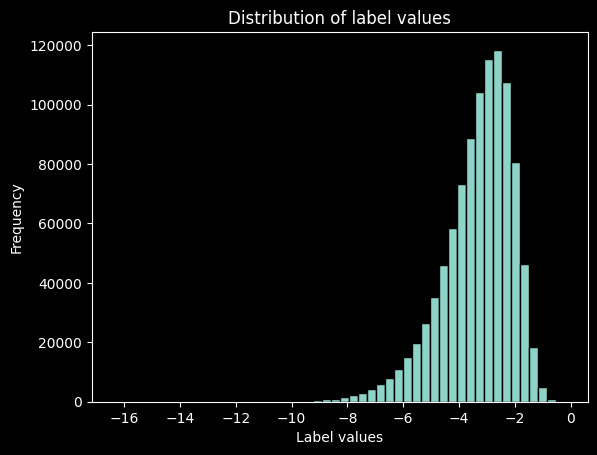

In [6]:
plt.style.use('dark_background')
plt.hist(energy_df, bins=50, edgecolor="black")

# add labels and title
plt.xlabel('Label values')
plt.ylabel('Frequency')
plt.title('Distribution of label values')
plt.show()
#Plot of the free energy labels in the entire dataset (training+test)

In [ ]:
df = pd.DataFrame(predictions, columns=["true", "predict"])
df = df.sort_values('true', ascending=True)
df.to_csv('data.csv', index=False)

In [2]:
#Start here if data.csv is already available
import pandas as pd
from sklearn.metrics import mean_squared_error

In [30]:
df = pd.read_csv('data.csv')

In [31]:
print(df["true"].mean())
print(df["predict"].mean())
print(df["true"].var())
print(df["predict"].var())
change = (df["predict"].var()/df["true"].var()-1)*100
print(f"{change:.2f}% variance change")
bias = df["predict"].mean() - df["true"].mean()
print("Bias:", bias)
mse = mean_squared_error(df['true'], df['predict']) 
print("MSE:", mse)

-3.3444169298785926
-3.613931269560456
1.6480939434500332
2.050099039899456
24.39% variance change
Bias: -0.26951433968186356
MSE: 0.15640475240276502


In [33]:
nrows = len(df)

# calculate the row indices for the four dataframes
indices = [0, int(nrows/4), int(nrows/2), int(3*nrows/4), nrows]

# split the dataframe into four parts
df1 = df.iloc[indices[0]:indices[1], :]
df2 = df.iloc[indices[1]:indices[2], :]
df3 = df.iloc[indices[2]:indices[3], :]
df4 = df.iloc[indices[3]:indices[4], :]

In [34]:
print(df1["true"].mean())
print(df1["predict"].mean())
print(df1["true"].var())
print(df1["predict"].var())
change = (df1["predict"].var()/df1["true"].var()-1)*100
print(f"{change:.2f}% variance change")
bias1 = df1["predict"].mean() - df1["true"].mean()
print("Bias:", bias1)
mse1 = mean_squared_error(df1['true'], df1['predict']) 
print("MSE:", mse1)

-5.1042546160125735
-5.546279947891235
1.0123730389034757
1.3016918702774098
28.58% variance change
Bias: -0.44202533187866155
MSE: 0.3500080830016833


In [35]:
print(df2["true"].mean())
print(df2["predict"].mean())
print(df2["true"].var())
print(df2["predict"].var())
change = (df2["predict"].var()/df2["true"].var()-1)*100
print(f"{change:.2f}% variance change")
bias2 = df2["predict"].mean() - df2["true"].mean()
print("Bias:", bias2)
mse2 = mean_squared_error(df2['true'], df2['predict']) 
print("MSE:", mse2)

-3.5342422819328307
-3.8354614467525483
0.06712383722660288
0.14644732888146372
118.17% variance change
Bias: -0.30121916481971756
MSE: 0.15641848534270264


In [36]:
print(df3["true"].mean())
print(df3["predict"].mean())
print(df3["true"].var())
print(df3["predict"].var())
change = (df3["predict"].var()/df3["true"].var()-1)*100
print(f"{change:.2f}% variance change")
bias3 = df3["predict"].mean() - df3["true"].mean()
print("Bias:", bias3)
mse3 = mean_squared_error(df3['true'], df3['predict']) 
print("MSE:", mse3)

-2.7710489375782013
-2.9849057734155653
0.03935028202795005
0.08768561501785845
122.83% variance change
Bias: -0.21385683583736403
MSE: 0.08447276574759723


In [37]:
print(df4["true"].mean())
print(df4["predict"].mean())
print(df4["true"].var())
print(df4["predict"].var())
change = (df4["predict"].var()/df4["true"].var()-1)*100
print(f"{change:.2f}% variance change")
bias4 = df4["predict"].mean() - df4["true"].mean()
print("Bias:", bias4)
mse4 = mean_squared_error(df4['true'], df4['predict']) 
print("MSE:", mse4)

-1.9681218839907646
-2.089077910182476
0.11751089245651318
0.16065932436493185
36.72% variance change
Bias: -0.12095602619171153
MSE: 0.03471967551907703


In [ ]:
import matplotlib.pyplot as plt

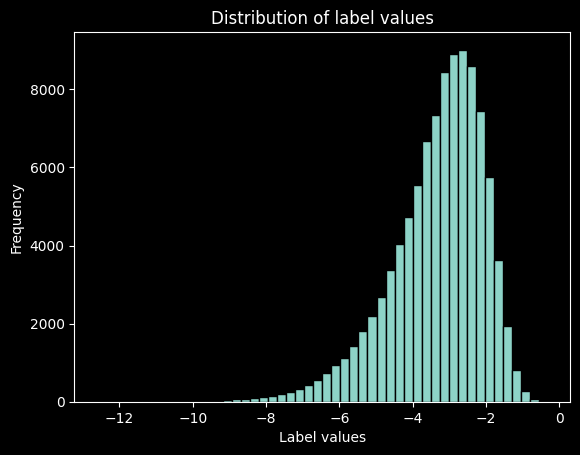

In [44]:
plt.style.use('dark_background')
plt.hist(df['true'], bins=50, edgecolor="black")

# add labels and title
plt.xlabel('Label values')
plt.ylabel('Frequency')
plt.title('Distribution of label values')
plt.show()